In [140]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Dim reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap # <== NOT a scikit-learn library, but follows the interface

import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

### Read EOD data

In [2]:
eod_data_df = pd.read_csv('/Users/shahbaz/Dropbox/uchicago_lecturer/data/raw/2025-09-10_OCHLV.csv.gz').set_index('ticker')
eod_data_df

,volume,open,close,high,low,window_start,transactions
ticker,,,,,,,
A,1669516,125.92,124.1200,126.7200,124.0100,1757476800000000000,26717
AA,6482517,31.30,30.9300,32.1000,30.7600,1757476800000000000,61601
AAA,1638,24.91,24.9450,24.9895,24.9100,1757476800000000000,40
AAAA,5767,26.18,26.2200,26.2600,26.1600,1757476800000000000,51
AAAU,2886007,36.02,35.9500,36.1000,35.8950,1757476800000000000,4858
...,...,...,...,...,...,...,...
ZXIET,2000,100.00,100.0000,100.0000,100.0000,1757476800000000000,1
ZYBT,117913,9.49,10.4000,11.0000,9.4900,1757476800000000000,1654
ZYME,519361,15.23,15.1900,15.5250,15.1443,1757476800000000000,7258


### Read market data file and calc mean trade size

In [3]:
%%time
tick_df = pd.read_csv('/Users/shahbaz/Dropbox/uchicago_lecturer/data/processed/2025-09-10_trades_small.csv.gz')
#tick_df.sip_timestamp = pd.to_datetime(tick_df.sip_timestamp, unit='ns')
tick_df.head()

CPU times: user 21.4 s, sys: 911 ms, total: 22.3 s
Wall time: 22.3 s


,ticker,price,size,sip_timestamp
0,A,125.51,10,1757495411299495662
1,A,125.36,2,1757502000119293992
2,A,126.25,1,1757505619324460220
3,A,126.00,5,1757506105447226225
4,A,126.05,5,1757506269015718369


In [4]:
mean_execution_size_df = tick_df[['ticker', 'size']].groupby('ticker').mean()
del tick_df

In [5]:
mean_execution_size_df.head()

,size
ticker,
A,102.000786
AA,147.367573
AAA,48.820000
AAAA,110.225806
AAAU,626.340522


### Create a security master with EOD data and mean_size column

In [81]:
sec_master_df = pd.concat([eod_data_df, mean_execution_size_df], axis=1)
sec_master_df.rename({'size':'mean_size'}, axis=1, inplace=True)
sec_master_df.dropna(inplace=True)
sec_master_df.drop(columns=['open', 'high', 'low', 'window_start'], inplace=True) #drop the columns we are not using

In [82]:
sec_master_df

,volume,close,transactions,mean_size
ticker,,,,
A,1669516.0,124.1200,26717.0,102.000786
AA,6482517.0,30.9300,61601.0,147.367573
AAA,1638.0,24.9450,40.0,48.820000
AAAA,5767.0,26.2200,51.0,110.225806
AAAU,2886007.0,35.9500,4858.0,626.340522
...,...,...,...,...
ZXIET,2000.0,100.0000,1.0,1333.333333
ZYBT,117913.0,10.4000,1654.0,73.365501
ZYME,519361.0,15.1900,7258.0,81.287386


**A note about this data being unrealistic**

The code below demonstrates unsupervised learning using scikit-learn. In a more realistic scenario, many other features could be considered. For example, stock prices are not stationry (in time-series terms), perhaps price changes could be included. 

Additionally, a better defined reason for clustering could suggest additional features. For example, if this clustering is being done for a smart order router, then time related featuers, such as seconds since the open, seconds since a halt, days until earnings, etc. could be included.

### Create clusters

In [83]:
cluster_input_cols = sec_master_df.columns.tolist()
cluster_input_cols

['volume', 'close', 'transactions', 'mean_size']

In [84]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=5, random_state=42, n_init='auto'))
])

In [85]:
model = pipeline.named_steps['kmeans']

In [86]:
model.n_clusters

5

The method `fit_transform` returns the distance between cluster centers (centroid) and each record. Not useful for data analysis

In [87]:
transformed_distances = pipeline.fit_transform(sec_master_df)
transformed_distances.shape

(11413, 5)

In [88]:
column_names = [f"distance_to_cluster_{i}" for i in range(model.n_clusters)]
df_distances = pd.DataFrame(transformed_distances, columns=column_names)
df_distances.head()

,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,distance_to_cluster_4
0,0.399568,43.964424,106.785222,68.680229,8.787013
1,1.278331,43.053284,106.807274,68.661326,7.888081
2,0.214852,44.498012,106.798036,68.708116,9.300559
3,0.204630,44.497453,106.797863,68.676721,9.299578
4,0.312935,44.193095,106.797504,68.408369,8.984267


The method `fit_predict` returns cluster labels for each input record

In [89]:
labels = pipeline.fit_predict(sec_master_df)
labels, labels.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32), (11413,))

The model object also provides labels, number of clusters, etc.

In [90]:
model.labels_, model.labels_.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32), (11413,))

Annotate the "security master" with cluster labels

In [91]:
sec_master_df['cluster_label'] = model.labels_.astype(pd.CategoricalDtype) # annotating types can often help with performance and memory usage
sec_master_df.head()

,volume,close,transactions,mean_size,cluster_label
ticker,,,,,
A,1669516.0,124.120,26717.0,102.000786,0
AA,6482517.0,30.930,61601.0,147.367573,0
AAA,1638.0,24.945,40.0,48.820000,0
AAAA,5767.0,26.220,51.0,110.225806,0
AAAU,2886007.0,35.950,4858.0,626.340522,0


Is the distribution of data points very skewed?

In [92]:
sec_master_df.cluster_label.value_counts()

cluster_label
0    11317
4       89
1        4
3        2
2        1
Name: count, dtype: int64

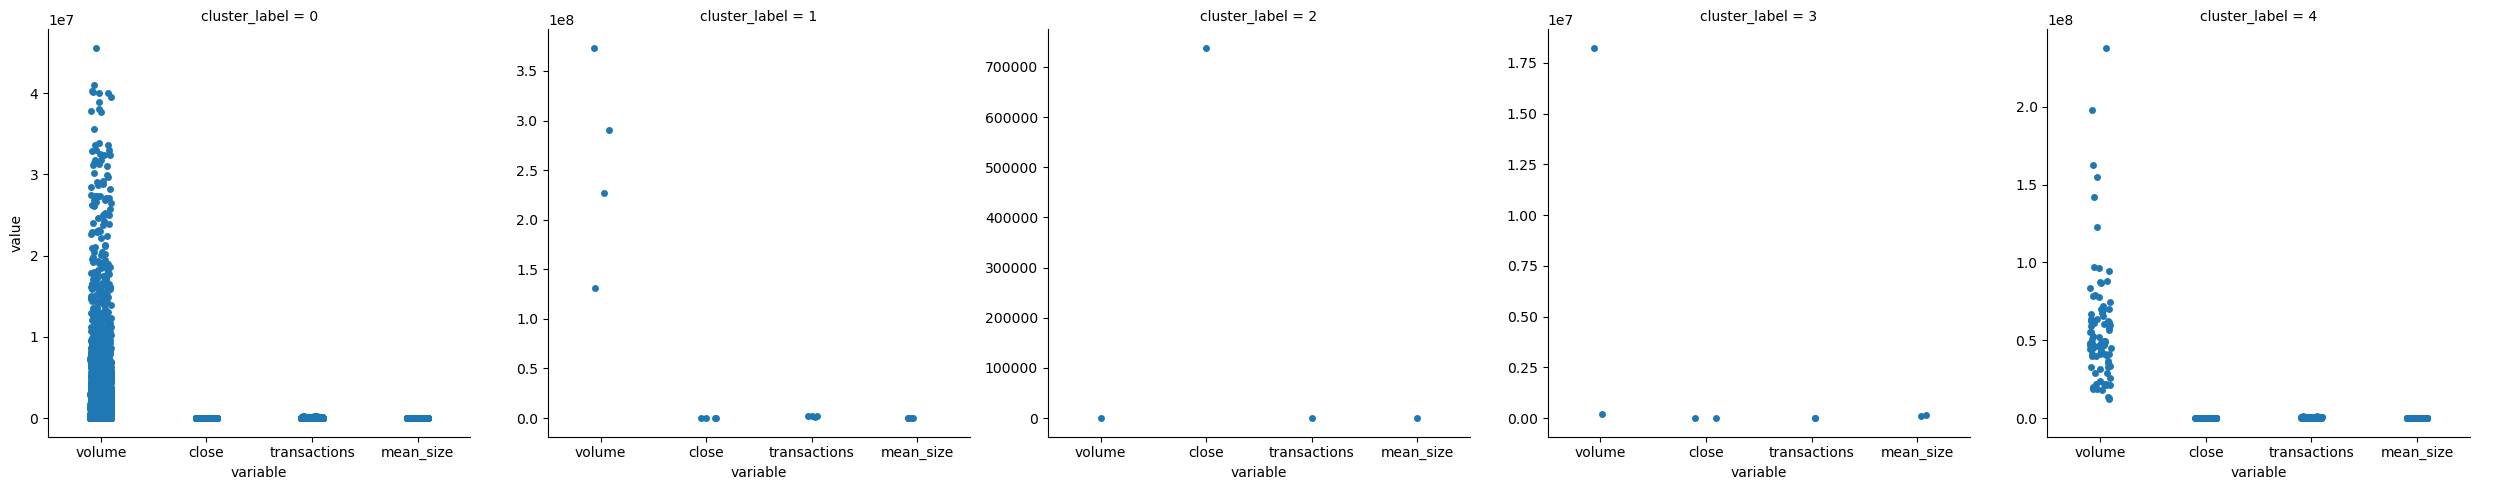

In [93]:
sns.catplot(
    data=pd.melt(sec_master_df, id_vars = 'cluster_label'), 
    x='variable', y='value', col='cluster_label', kind='strip', col_wrap=5, sharey=False
)

Could it be that we should not have picked 5 clusters?

### Pick the right cluster size

Let's try different cluster sizes and measure their performance.

Notice that if we use a Pipeline inside the loop, we are computing the StandardScaler multiple times for the same data. This wastes cpu cycles! Let's break apart the two tasks and bring them together in a pipeline later

```python
for i in range(2, 10 + 1):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=5, random_state=42, n_init='auto'))
    ])
    ...
```

In [94]:
sec_master_scaled_df = StandardScaler().fit_transform(sec_master_df)

In [110]:
%%time
inertia_scores = list()
silhouette_scores = list()

for i in range (2, 10 +1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(sec_master_scaled_df)
    
    inertia_scores.append(kmeans.inertia_) # <= Needed for the "elbow" method

    silhouette_scores.append(silhouette_score(sec_master_scaled_df, cluster_labels) ) # <= Needed for the "silhouette" score method

CPU times: user 20.2 s, sys: 46 s, total: 1min 6s
Wall time: 9.09 s


**Elbow method**

This is perhaps the most standard way to determine the correct size for a cluster. Data scientists visually review the part of the chart which has the sharpest "kink" or "elbow". In the chart below, that value is 4 or 5

The elbow method calculates the Within-Cluster Sum of Squared (WCSS) distances. 

<Axes: xlabel='k'>

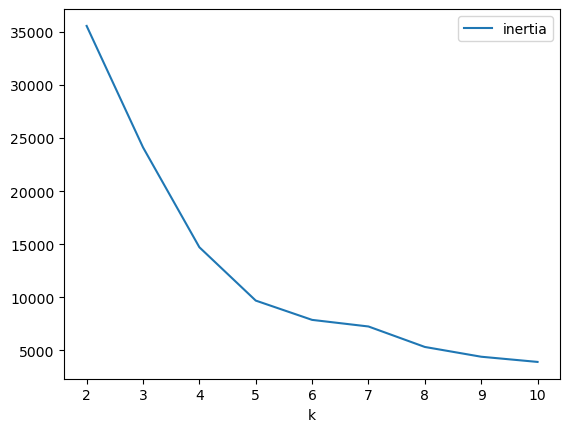

In [103]:
pd.DataFrame({'k':range(2,10+1), 'inertia':inertia_scores}).plot.line(x='k', y='inertia')

**Silhouette method**

Another way to determine the correct cluster size is to measure the mean distance to all other points in the _same_ cluster and the mean distance to every point in the _nearest neighboring_ cluster. A ratio of these numbers is called the "silhouette score." [1] Higher values are better.

> "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
" - Scikit learn docs

Note that 'cohesion' and 'separation' are related measures and often useful measuring the quality of clusters, such as text topic models.

[1] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

<Axes: xlabel='k'>

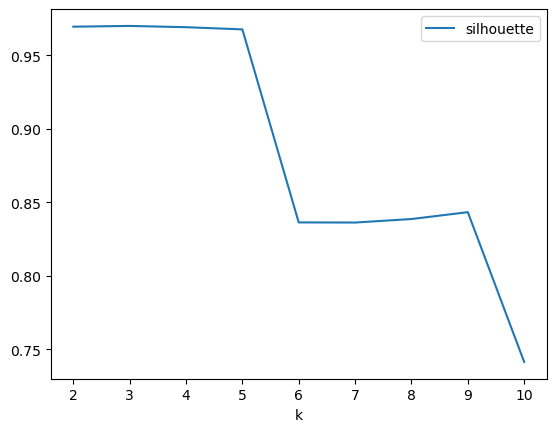

In [111]:
pd.DataFrame({'k':range(2,10+1), 'silhouette':silhouette_scores}).plot.line(x='k', y='silhouette')

### Pick a better cluster size
Given this analysis, let's pick the cluster size to be 4

In [127]:
%%time

CLUSTER_SIZE = 4

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=CLUSTER_SIZE, random_state=42, n_init='auto'))
])

labels = pipeline.fit_predict(sec_master_df)
labels, labels.shape

model = pipeline.named_steps['kmeans']

sec_master_df['cluster_label'] = model.labels_.astype(pd.CategoricalDtype) # annotating types can often help with performance and memory usage

CPU times: user 326 ms, sys: 10.8 ms, total: 337 ms
Wall time: 46.6 ms


In [139]:
model.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 'auto',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

### Investigate clusters

Books and internet examples (and LLMs!) often build for loops to iterate through various clusters and build cluster specific charts. In the example below, we use Pandas' `melt` function to created "faceted" charts.

In [128]:
sec_master_df

,volume,close,transactions,mean_size,cluster_label
ticker,,,,,
A,1669516.0,124.1200,26717.0,102.000786,0
AA,6482517.0,30.9300,61601.0,147.367573,0
AAA,1638.0,24.9450,40.0,48.820000,0
AAAA,5767.0,26.2200,51.0,110.225806,0
AAAU,2886007.0,35.9500,4858.0,626.340522,0
...,...,...,...,...,...
ZXIET,2000.0,100.0000,1.0,1333.333333,0
ZYBT,117913.0,10.4000,1654.0,73.365501,0
ZYME,519361.0,15.1900,7258.0,81.287386,0


Unpivot the dataframe (see Pandas lecture on pivot/melt)

In [129]:
pd.melt(filtered_on_cluster_df)

,variable,value
0,volume,2.268520e+08
1,volume,3.732721e+08
2,volume,1.316181e+08
3,volume,2.902029e+08
4,close,1.773300e+02
5,close,5.860000e+00
6,close,3.283300e+02
7,close,5.180000e+00
8,transactions,2.122717e+06
9,transactions,5.868380e+05


In [130]:
pd.melt(sec_master_df[sec_master_df.columns], id_vars = 'cluster_label')

,cluster_label,variable,value
0,0,volume,1.669516e+06
1,0,volume,6.482517e+06
2,0,volume,1.638000e+03
3,0,volume,5.767000e+03
4,0,volume,2.886007e+06
...,...,...,...
45647,0,mean_size,1.333333e+03
45648,0,mean_size,7.336550e+01
45649,0,mean_size,8.128739e+01
45650,0,mean_size,3.527536e+01


In [131]:
pd.melt(sec_master_df, id_vars = 'cluster_label')

,cluster_label,variable,value
0,0,volume,1.669516e+06
1,0,volume,6.482517e+06
2,0,volume,1.638000e+03
3,0,volume,5.767000e+03
4,0,volume,2.886007e+06
...,...,...,...
45647,0,mean_size,1.333333e+03
45648,0,mean_size,7.336550e+01
45649,0,mean_size,8.128739e+01
45650,0,mean_size,3.527536e+01


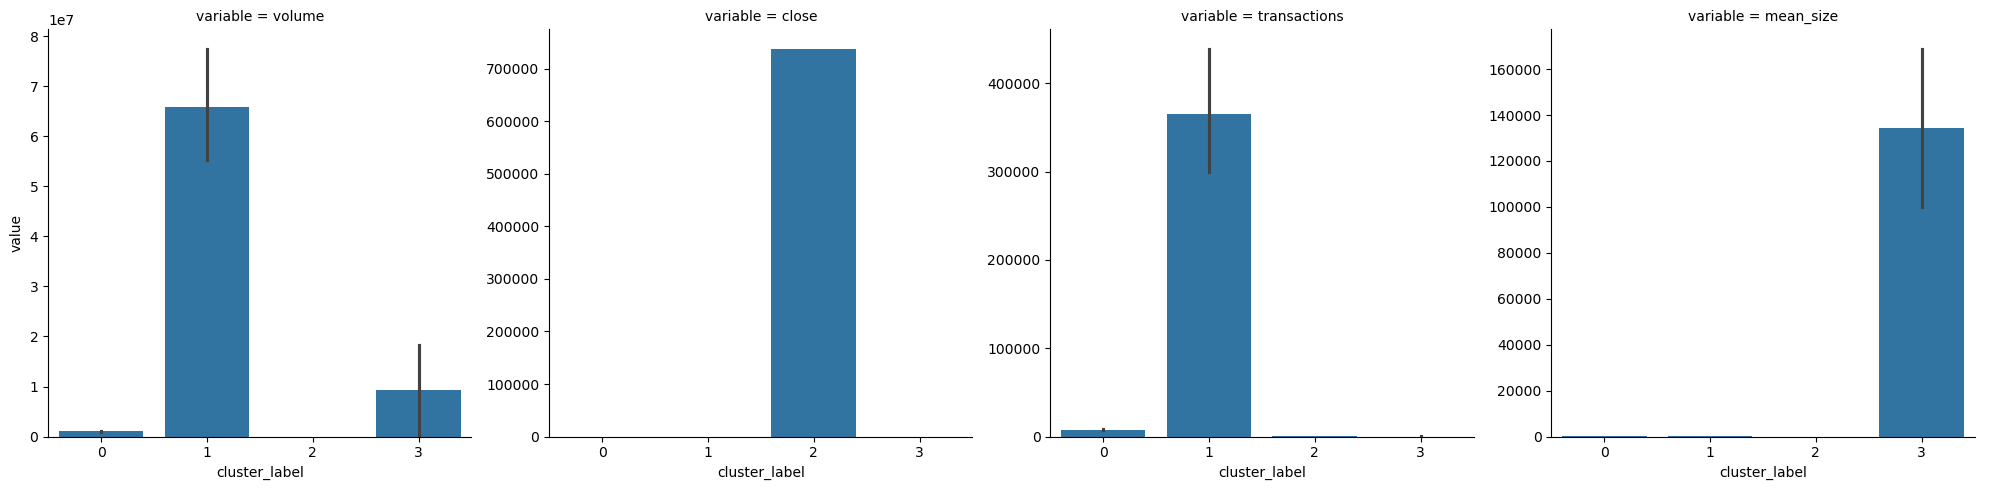

In [132]:
sns.catplot(
    data=pd.melt(sec_master_df, id_vars = 'cluster_label'), 
    x='cluster_label', y='value', col='variable', kind='bar', col_wrap=4, sharey=False
)

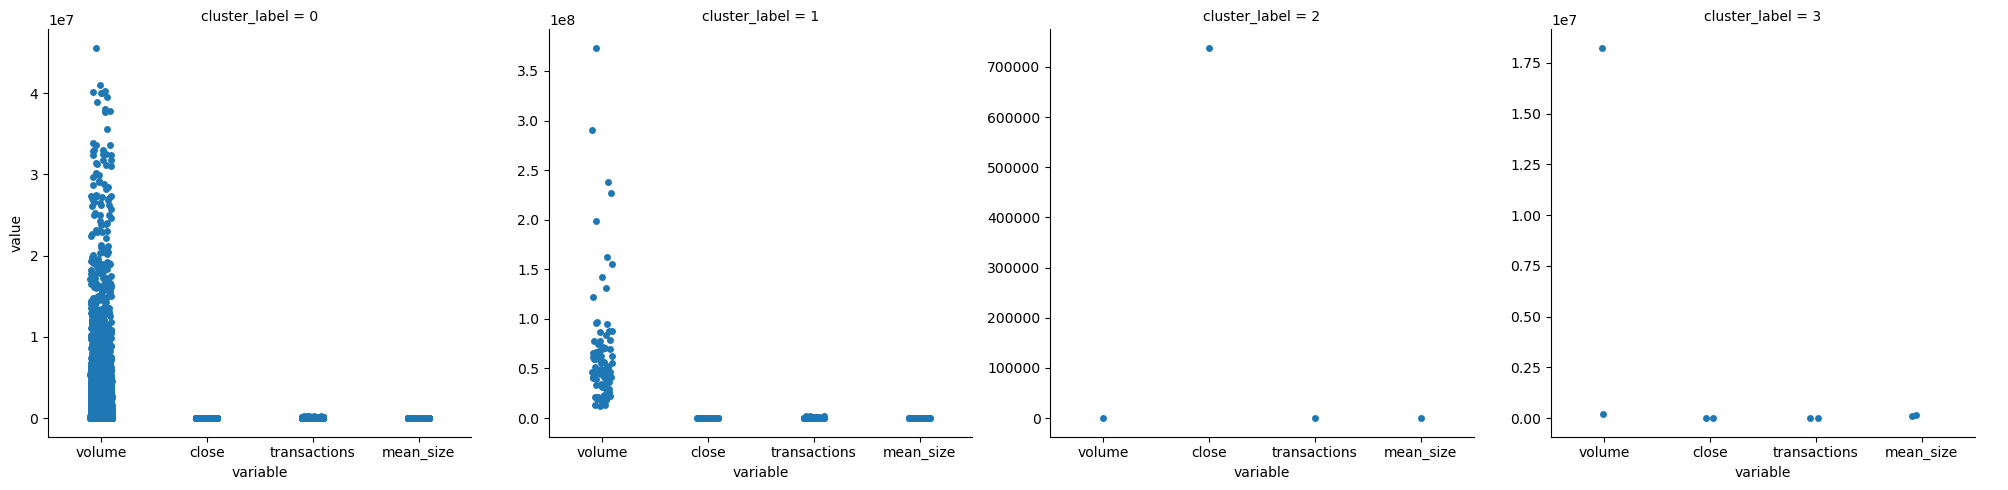

In [133]:
sns.catplot(
    data=pd.melt(sec_master_df, id_vars = 'cluster_label'), 
    x='variable', y='value', col='cluster_label', kind='strip', col_wrap=4, sharey=False
)

### For good measure: try DBSCAN

In [149]:
%%time

pipeline_dbs = Pipeline([
    ('scaler', StandardScaler()),
    ('dbscan', DBSCAN())
])

pipeline_dbs.fit(sec_master_df)

model_dbs = pipeline_dbs.named_steps['dbscan']

sec_master_df['cluster_label'] = model_dbs.labels_.astype(pd.CategoricalDtype) # annotating types can often help with performance and memory usage

CPU times: user 573 ms, sys: 79.5 ms, total: 653 ms
Wall time: 650 ms


In [150]:
model_dbs.get_params()

{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

Cluster -1 is noise

In [170]:
n_clusters_dbs = len(set([int(l) for l in model_dbs.labels_ if l != -1]))
n_clusters_dbs

3

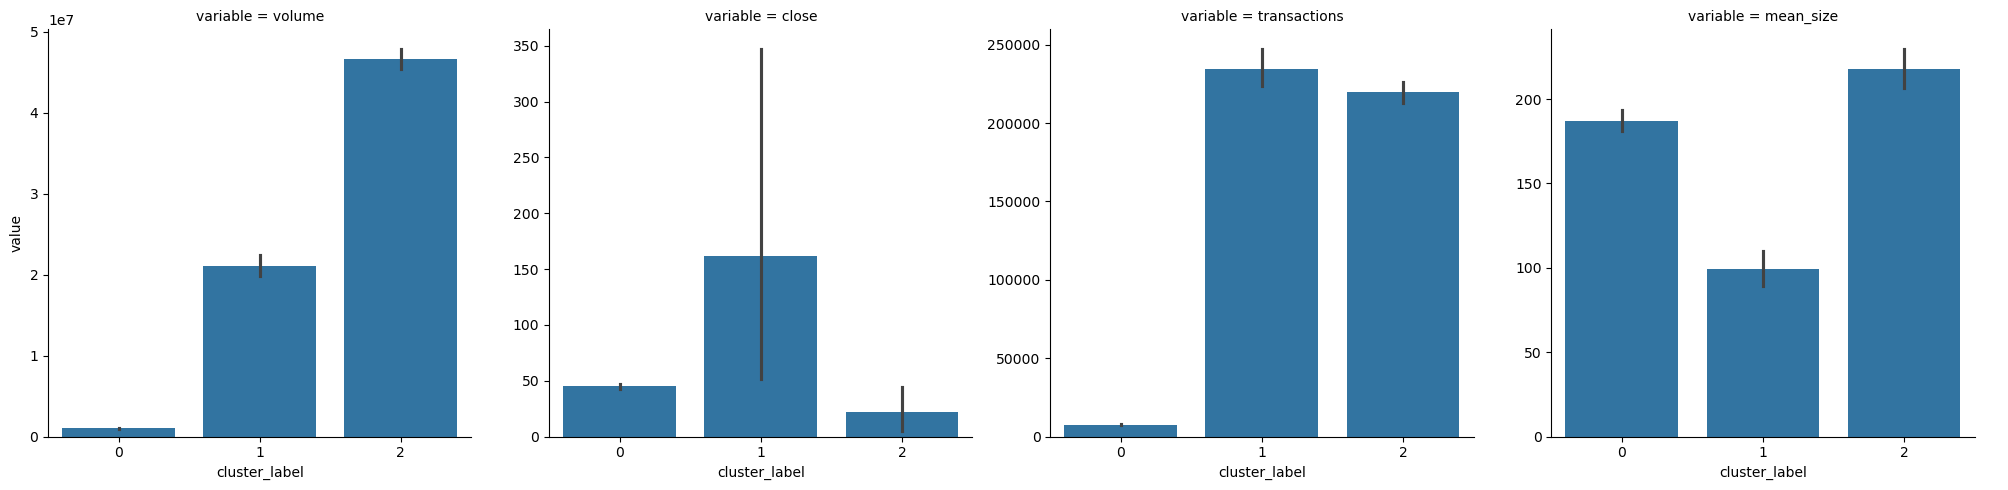

In [167]:
sns.catplot(
    data=pd.melt(sec_master_df[sec_master_df.cluster_label != -1], id_vars = 'cluster_label'), 
    x='cluster_label', y='value', col='variable', kind='bar', col_wrap=4, sharey=False
)

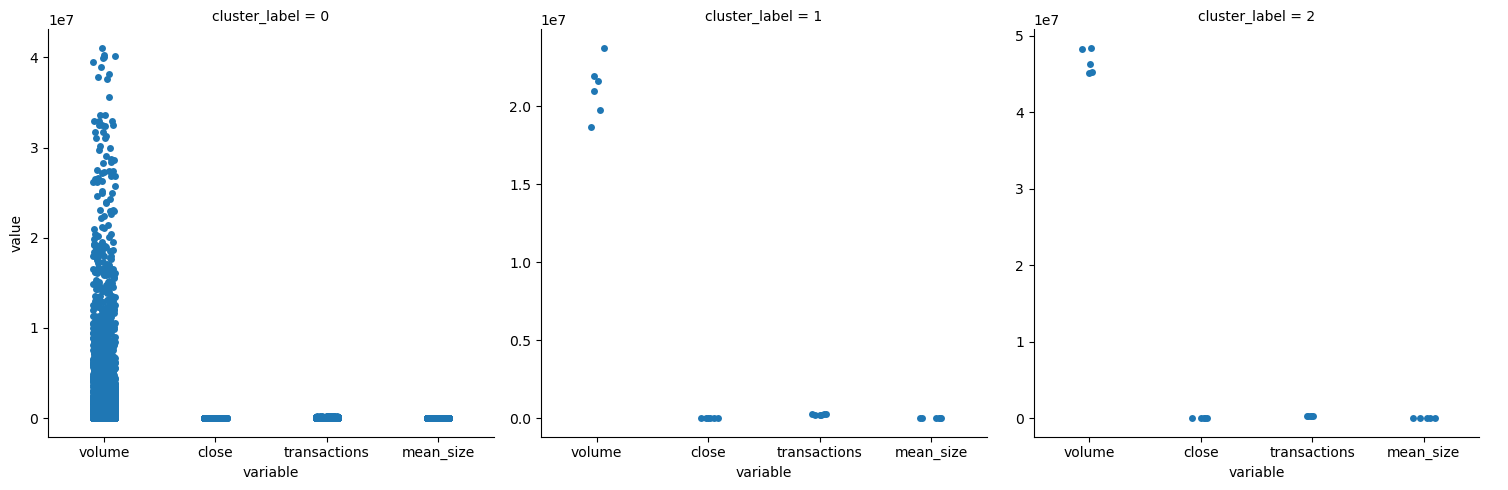

In [171]:
sns.catplot(
    data=pd.melt(sec_master_df[sec_master_df.cluster_label != -1], id_vars = 'cluster_label'), 
    x='variable', y='value', col='cluster_label', kind='strip', col_wrap=n_clusters_dbs, sharey=False
)

### Reduce dimensions and plot

PCA

CPU times: user 33.1 ms, sys: 2.18 ms, total: 35.3 ms
Wall time: 33.4 ms


<Axes: xlabel='x', ylabel='y'>

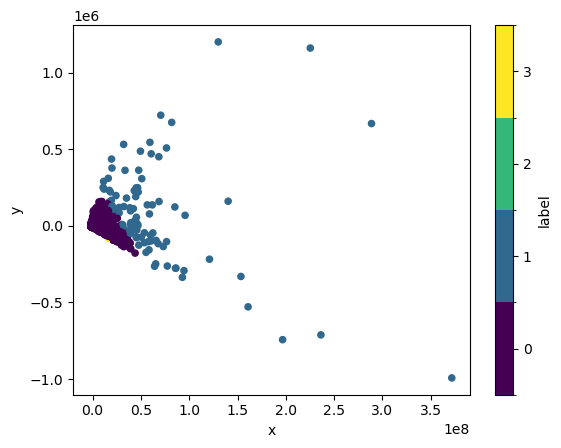

In [134]:
%%time
X_reduced = PCA(n_components=2).fit_transform(sec_master_df)
X_reduced.shape

pd.concat([
    pd.DataFrame(X_reduced, columns=['x', 'y']), 
    pd.DataFrame({'label':pd.Series(model.labels_, dtype='category')})]
    , axis=1)\
    .plot.scatter(x='x', y='y', c='label', colormap='viridis')

TSNE

CPU times: user 1min 35s, sys: 1min 16s, total: 2min 52s
Wall time: 11.1 s


<Axes: xlabel='x', ylabel='y'>

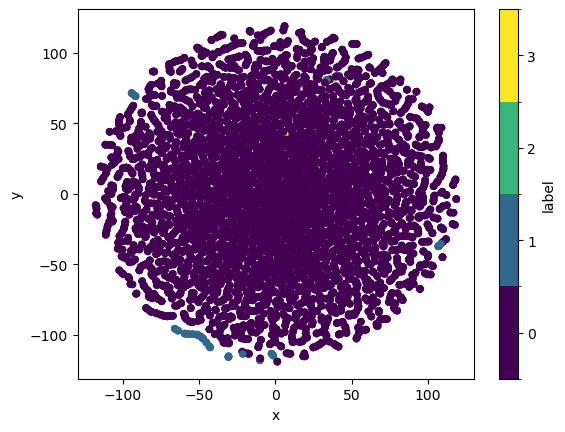

In [135]:
%%time
X_reduced = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(sec_master_df)
X_reduced.shape

pd.concat([
    pd.DataFrame(X_reduced, columns=['x', 'y']), 
    pd.DataFrame({'label':pd.Series(model.labels_, dtype='category')})]
    , axis=1)\
    .plot.scatter(x='x', y='y', c='label', colormap='viridis')

UMAP

CPU times: user 1min 12s, sys: 7.08 s, total: 1min 19s
Wall time: 5.27 s


<Axes: xlabel='x', ylabel='y'>

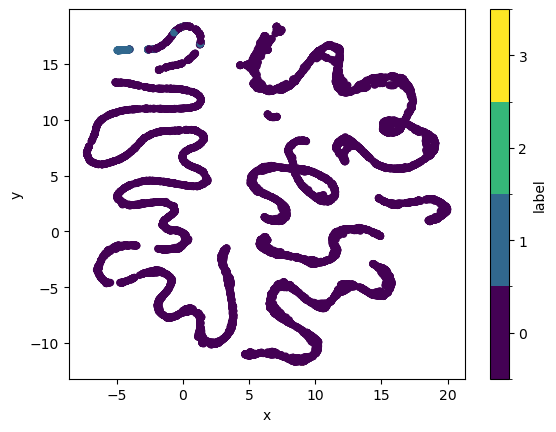

In [137]:
%%time
X_reduced = umap.UMAP().fit_transform(sec_master_df) # <== Thsi is not even from scikit-learn!
X_reduced.shape

pd.concat([
    pd.DataFrame(X_reduced, columns=['x', 'y']), 
    pd.DataFrame({'label':pd.Series(model.labels_, dtype='category')})]
    , axis=1)\
    .plot.scatter(x='x', y='y', c='label', colormap='viridis')

### Read executions file

In [ ]:
#executions_df = pd.read_csv('/Users/shahbaz/Dropbox/uchicago_lecturer/data/processed/trades_from_fix.csv.gz', parse_dates=['order_time', 'execution_time']).set_index('symbol')
#executions_df

In [ ]:
#executions_df.columns

### Explore

Which symbols in the execution file do not have entries in market data files?

In [ ]:
#pd.Index(executions_df.symbol).difference(tick_df.ticker)